In [1]:
import torchvision
import torch
from torchvision import datasets, transforms
from mlxtend.data import loadlocal_mnist #load the MNIST from local
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
#from sklearn import datasets, model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import torch.nn.functional as F
import os.path as osp

### Load the MNIST Dataset from loacl file

In [2]:
train_image, train_label  = loadlocal_mnist(
            images_path='dataset/MNIST/raw/train-images-idx3-ubyte', 
            labels_path='dataset/MNIST/raw/train-labels-idx1-ubyte')
test_image, test_label = loadlocal_mnist(
            images_path='dataset/MNIST/raw/t10k-images-idx3-ubyte', 
            labels_path='dataset/MNIST/raw/t10k-labels-idx1-ubyte'
)
# load and verify the loaded dataset
print('Train Data Dimensions: %s x %s' % (train_image.shape[0], train_image.shape[1]))
print('# of Train labels', train_label.shape[0])
print('Test Data Dimensions: %s x %s' % (test_image.shape[0], test_image.shape[1]))
print('# of Test labels', test_label.shape[0])

Train Data Dimensions: 60000 x 784
# of Train labels 60000
Test Data Dimensions: 10000 x 784
# of Test labels 10000


### KNN Classifier

In [135]:
def sad_knn(k, test_image, train_image, train_label):
    """ k: # of neighbors
        using hamming distance to compute the SAD simlarity of images
    """
    cls = KNeighborsClassifier(n_neighbors=k, p=1,metric='minkowski')
    cls.fit(train_image,train_label)
    pred = np.array(cls.predict(test_image))
    return pred

Text(0.5, 1.0, 'K-NN accuracy over # of K')

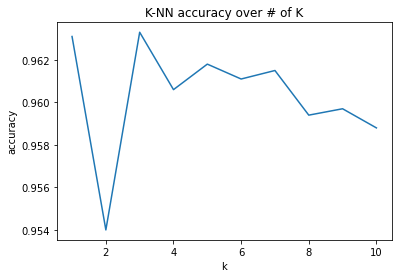

In [136]:
acc = [accuracy_score (test_label, sad_knn(i, test_image, train_image, train_label)) for i in range(1,11)]
k = [i for i in range(1,11)]
fig = plt.figure()
plt.plot(k,acc)
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title("K-NN accuracy over # of K")

### Multilayer Perceptron (MLP)

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #set up for gpu support if available
mlp_model_path = "model/MLP"
transform = transforms.Compose([transforms.ToTensor()])
data_train = datasets.MNIST(root = "dataset",
                            transform=transform,
                            train = True,
                            download = True)

data_test = datasets.MNIST(root="dataset",
                           transform = transform,
                           train = False)
batch_size = 64

data_loader_train = torch.utils.data.DataLoader(dataset=data_train,
                                                batch_size = batch_size,
                                                shuffle = True,
                                                num_workers=2)

data_loader_test = torch.utils.data.DataLoader(dataset=data_test,
                                               batch_size = batch_size,
                                               shuffle = False,
                                               num_workers=2)

#### Display a batch of datas

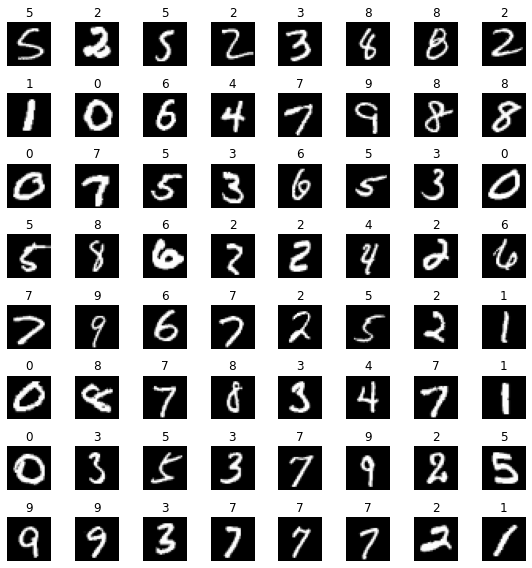

In [8]:
# Display a batch of data
train_features, train_labels = next(iter(data_loader_train)) #use iterator to iterate over the dataset
figure = plt.figure(figsize=(8, 8))
cols, rows = 8, 8
for i in range(1, cols * rows+1):
    img = train_features[i-1].squeeze()
    figure.add_subplot(rows, cols, i)
    plt.title(f"{train_labels[i-1]}")
    plt.axis("off")
    plt.imshow(img, cmap="gray")
    plt.tight_layout()
plt.show()

In [23]:
class MLP(torch.nn.Module):
    """ Input layer 28*28=784d vector
        Two hidden layer, exclude input and output layer
        Each hidden layer is fully-connected layer followed by ReLU
        Use entropy loss 
        try # of neurons 4, 8, 16, 32, 64, 128, and 256.
    """
    def __init__(self, num_neurons):
        super(MLP, self).__init__()

        self.fc1 = torch.nn.Linear(784,num_neurons)
        self.fc2 = torch.nn.Linear(num_neurons,num_neurons)
        self.fc3 = torch.nn.Linear(num_neurons,10)

       
    def forward(self, x_in):
        x_in = x_in.view(-1,28*28)
        x = F.relu(self.fc1(x_in))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim =1)
        return x

In [24]:
def train_mlp(mlp, training_set , validation_set, epoch, num_neurons):
    """ mlp: model
        training_set: data_loader_training
        validation_set: data_loader_test
        epoch: number of epoch
    """
    lossfunc = torch.nn.CrossEntropyLoss()
    #mlp = MLP(num_neurons=num_neurons).to(device=device)
    optimizer = torch.optim.SGD(mlp.parameters(), lr = 0.01, momentum=0.9)
    EPOCHS = epoch
    epoch_number = 0
    train_accuracy = []
    for epoch in range(EPOCHS):
        #print('EPOCH {}:'.format(epoch_number + 1))
        mlp.train(True)
        avg_loss = train_one_epoch(mlp, training_set, optimizer=optimizer, lossfunc=lossfunc)
        mlp.train(False)
        running_vloss = 0.0
        corrlabel = 0.
        samples = 0.
        for i, vdata in enumerate(validation_set):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.to(device)
            voutputs = mlp(vinputs)
            vloss = lossfunc(voutputs, vlabels)
            running_vloss += vloss
            predit =  voutputs.cpu().detach().numpy().argmax(axis=1)
            #print(predit)
            labels = vlabels.cpu().detach().numpy()
            corrlabel += np.sum(predit == labels)
            #print(corrlabel)
            samples += batch_size
        avg_vloss = running_vloss / (i + 1)
        train_accuracy.append(corrlabel/samples)
        #print('LOSS train {} valid {} '.format(avg_loss, avg_vloss))
        #print('LOSS train {} valid {} tranining accuracy {:.2f}'.format(avg_loss, avg_vloss, train_accuracy[epoch_number]*100))
        epoch_number += 1
    torch.save(mlp.state_dict(), osp.join(mlp_model_path, "{}neurons.pt".format(num_neurons)))
    return train_accuracy

# define train one epoch
def train_one_epoch(model, data_loader_train, optimizer, lossfunc):
    running_loss = 0.
    last_loss = 0.
    count = 0.
    for i, data in enumerate(data_loader_train):
        inputs, labels = data
        inputs = inputs.to(device=device)
        labels = labels.to(device=device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = lossfunc(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        count+=1
    last_loss = running_loss/count
    return last_loss

def inference(mlp, data_loader_test):
    train_accuracy=[]
    predicts = []
    corrlabel = 0
    samples = 0
    for i, vdata in enumerate(data_loader_test):
        vinputs, vlabels = vdata
        vinputs = vinputs.to(device)
        vlabels = vlabels.to(device)
        voutputs = mlp(vinputs)
        predit =  voutputs.cpu().detach().numpy().argmax(axis=1)
        labels = vlabels.cpu().detach().numpy()
        corrlabel += np.sum(predit == labels)
        #print(corrlabel)
        samples += batch_size
        predicts.append(predit)
    train_accuracy=corrlabel/samples
    return train_accuracy


In [26]:
mlp = MLP(256).to(device=device)
accuracy = train_mlp(mlp, data_loader_train, data_loader_test, 20, 256)
print('accuracy of model with 256 neurons is {:.2f}%'.format(accuracy[-1]*100))

accuracy of model with 256 neurons is96.03%


In [191]:
model_acc = []
neurons = [4, 8, 16, 32, 64, 128, 256]
for i in neurons:
    mlp = MLP(i).to(device=device)
    if osp.exists(osp.join(mlp_model_path, "{}neurons.pt".format(i))):
        mlp.load_state_dict(torch.load(osp.join(mlp_model_path, "{}neurons.pt".format(i))))
        acc = inference(mlp, data_loader_test)
        model_acc.append(acc) 
    else:
        acc = train_mlp(mlp, data_loader_train, data_loader_test, 20, i)
        model_acc.append(acc)

Text(0.5, 1.0, 'MLP accuracy over # of neurons')

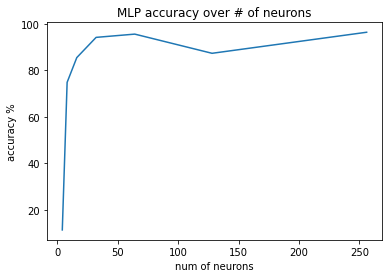

In [219]:
plt.figure()
plt.plot(neurons,np.array(model_acc)*100)
plt.xlabel('num of neurons')
plt.ylabel('accuracy %')
plt.title("MLP accuracy over # of neurons")

## CNN LeNet-5

In [12]:
class LeNet5(torch.nn.Module):
   def __init__(self):
       super().__init__()
       self.conv1 = torch.nn.Conv2d(1, 6, 5) # output 24 * 24 * 6
       self.avgp1 = torch.nn.AvgPool2d(kernel_size=2, stride=2) # output 12 * 12 * 6  
       self.conv2 = torch.nn.Conv2d(6, 16, 5) # output 8 * 8 * 16
       self.avgp2 = torch.nn.AvgPool2d(kernel_size=2, stride= 2) # output 4 * 4 * 16 
       self.flat = torch.nn.Flatten()
       self.fc1 = torch.nn.Linear(4*4*16, 120)
       self.fc2 = torch.nn.Linear(120, 84)
       self.fc3 = torch.nn.Linear(84, 10)

   def forward(self, x):
       x = F.relu(self.conv1(x))
       x = self.avgp1(x)
       x = F.relu(self.conv2(x))
       x = self.avgp2(x)
       x = self.flat(x)
       x = F.relu(self.fc1(x))
       x = F.relu(self.fc2(x))
       x = F.softmax(self.fc3(x), dim =1)
       return x

In [15]:
lossfunc = torch.nn.CrossEntropyLoss()
cnn_model_path = "model/LeNet"
def train_lenet(LeNet5, data_loader_train, validation_set, epoch):
    optimizer = torch.optim.SGD(LeNet5.parameters(), lr = 0.01, momentum=0.9)
    EPOCHS = epoch
    epoch_number = 0
    train_accuracy = []
    for epoch in range(EPOCHS):
        LeNet5.train(True)
        running_loss = 0.
        count = 0.
        #train one epoch
        for i , data in enumerate(data_loader_train):
            inputs, labels = data
            inputs = inputs.to(device=device)
            labels = labels.to(device=device)
            optimizer.zero_grad()
            outputs = LeNet5(inputs)
            loss = lossfunc(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            count+=1
            last_loss = running_loss/count
        avg_loss = last_loss
        LeNet5.train(False)
        running_vloss = 0.0
        corrlabel = 0.
        samples = 0.
        for i, vdata in enumerate(validation_set):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.to(device)
            voutputs = LeNet5(vinputs)
            vloss = lossfunc(voutputs, vlabels)
            running_vloss += vloss
            predit =  voutputs.cpu().detach().numpy().argmax(axis=1)
            #print(predit)
            labels = vlabels.cpu().detach().numpy()
            corrlabel += np.sum(predit == labels)
            #print(corrlabel)
            samples += batch_size
        avg_vloss = running_vloss / (i + 1)
        train_accuracy.append(corrlabel/samples)
        #print('LOSS train {} valid {} '.format(avg_loss, avg_vloss))
        #print('LOSS train {} valid {} tranining accuracy {:.2f}'.format(avg_loss, avg_vloss, train_accuracy[epoch_number]*100))
        epoch_number += 1
    torch.save(LeNet5.state_dict(), osp.join(cnn_model_path, ".pt"))
    return train_accuracy


In [21]:
cnn = LeNet5().to(device=device)
cnn_acc = train_lenet(cnn, data_loader_train, data_loader_test, 20)

Accuracy of the model 97.54%


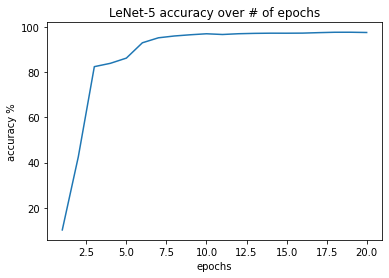

In [22]:
plt.figure()
p = [i+1 for i in range(20)]
acc = np.array(cnn_acc)*100
plt.plot( p ,acc)
plt.xlabel('epochs')
plt.ylabel('accuracy %')
plt.title("LeNet-5 accuracy over # of epochs")
print('Accuracy of the model {:.2f}%'.format(acc[-1]))

## Context Aggregation Networks (CAN)

In [3]:
class CAN(torch.nn.Module):
    def __init__(self, feature_channels):
        super(CAN, self).__init__()

        self.conv1 = torch.nn.Conv2d( in_channels=1, 
                                      out_channels=feature_channels,
                                      kernel_size=3,
                                      dilation=1,
                                      padding=1)
                                      # output = 28
        self.conv2 = torch.nn.Conv2d( in_channels=feature_channels,
                                      out_channels=feature_channels,
                                      kernel_size=3,
                                      dilation=2,
                                      padding=2)
                                      # output = 28
        self.conv3 = torch.nn.Conv2d( in_channels=feature_channels,
                                      out_channels=feature_channels,
                                      kernel_size=3,
                                      dilation=4,
                                      padding=4)
                                      # output = 28
        self.conv4 = torch.nn.Conv2d( in_channels=feature_channels,
                                      out_channels=feature_channels,
                                      kernel_size=3,
                                      dilation=8,
                                      padding=8)
                                      # output = 28
        self.conv5 = torch.nn.Conv2d( in_channels=feature_channels,
                                      out_channels=10,
                                      kernel_size=3,
                                      dilation=1,
                                      padding=1)
                                      # output = 28
        self.avgp = torch.nn.AvgPool2d(kernel_size=28)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        x = F.leaky_relu(self.conv5(x))
        x = self.avgp(x)
        x = F.softmax(torch.squeeze(x), dim =1)
        return x

In [4]:
from torch.cuda.amp import autocast as autocast
lossfunc = torch.nn.CrossEntropyLoss()
can_model_path = "model/CAN"
def train_can(can, data_loader_train, validation_set, epoch, num_c):
    LeNet5 = can
    #optimizer = torch.optim.Adam(LeNet5.parameters())
    optimizer = torch.optim.SGD(LeNet5.parameters() , lr = 0.01, momentum=0.9)
    EPOCHS = epoch
    epoch_number = 0
    train_accuracy = []
    for epoch in range(EPOCHS):
        LeNet5.train(True)
        running_loss = 0.
        count = 0.
        #train one epoch
        for i , data in enumerate(data_loader_train):
            inputs, labels = data
            inputs = inputs.to(device=device)
            labels = labels.to(device=device)
            optimizer.zero_grad()
            with autocast():
                outputs = LeNet5(inputs)
                loss = lossfunc(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            count+=1
            last_loss = running_loss/count
        avg_loss = last_loss
        LeNet5.train(False)
        running_vloss = 0.0
        corrlabel = 0.
        samples = 0.
        for i, vdata in enumerate(validation_set):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.to(device)
            with autocast():
                voutputs = LeNet5(vinputs)
                vloss = lossfunc(voutputs, vlabels)
            running_vloss += vloss
            predit =  voutputs.cpu().detach().numpy().argmax(axis=1)
            #print(predit)
            labels = vlabels.cpu().detach().numpy()
            corrlabel += np.sum(predit == labels)
            #print(corrlabel)
            samples += batch_size
        avg_vloss = running_vloss / (i + 1)
        train_accuracy.append(corrlabel/samples)
        #print('LOSS train {} valid {} '.format(avg_loss, avg_vloss))
        #print('LOSS train {} valid {} tranining accuracy {:.2f}'.format(avg_loss, avg_vloss, train_accuracy[epoch_number]*100))
        epoch_number += 1
    torch.save(can.state_dict(), osp.join(can_model_path, "{}channels.pt".format(num_c)))
    return train_accuracy

def inference_can(mlp, data_loader_test):
    train_accuracy=[]
    predicts = []
    corrlabel = 0
    samples = 0
    for i, vdata in enumerate(data_loader_test):
        vinputs, vlabels = vdata
        vinputs = vinputs.to(device)
        vlabels = vlabels.to(device)
        with autocast():
            voutputs = mlp(vinputs)
        predit =  voutputs.cpu().detach().numpy().argmax(axis=1)
        labels = vlabels.cpu().detach().numpy()
        corrlabel += np.sum(predit == labels)
        #print(corrlabel)
        samples += batch_size
        predicts.append(predit)
    train_accuracy=corrlabel/samples
    return train_accuracy


In [5]:
feature_channels = [8,16,32]
model_acc = []
for i in feature_channels:
    can = CAN(i).to(device=device)
    if osp.exists(osp.join(can_model_path, "{}channels.pt".format(i))):
        can.load_state_dict(torch.load(osp.join(can_model_path, "{}channels.pt".format(i))))
        acc = inference_can(can, data_loader_test)
        model_acc.append(acc)
        torch.cuda.empty_cache()
    else:
        acc = train_can(can, data_loader_train, data_loader_test, 20 ,i)
        model_acc.append(acc)

[67.96377389 60.5294586  69.76512739]


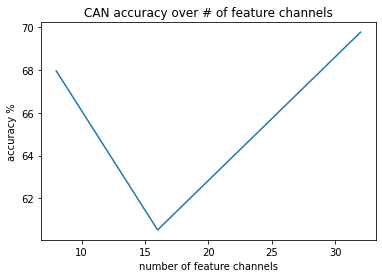

In [9]:
plt.figure()
p = [i for i in feature_channels]
can_acc = np.array(model_acc)*100
plt.plot( p ,can_acc)
plt.xlabel('number of feature channels')
plt.ylabel('accuracy %')
plt.title("CAN accuracy over # of feature channels")
print(can_acc)

The accuracy of CAN is 69.77% for 32 feature channels, 60.53% for 16 feature channels and 67.96% for 8 feature channels.